In [1]:
import pyspark

In [2]:
import findspark
findspark.init()
findspark.find()

'C:\\Spark'

In [3]:
# Import SparkSession from pyspark.sql
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType
from pyspark.sql.functions import col, isnan, when, count, udf, year, month, to_date, mean, explode
import pyspark.sql.functions as F
import seaborn as sns
import matplotlib.pyplot as plt

# Create my_spark
spark = SparkSession.builder.getOrCreate()
print(spark)

In [4]:
# Read File A
spark_weather_df_a = spark.read \
    .option("header", False) \
    .option("sep", ",") \
    .option("inferSchema", True) \
    .csv(path=f'data/weather/zurich_weather_a.csv')
    
spark_weather_df_a.printSchema()
spark_weather_df_a.describe().show()

root
 |-- _c0: integer (nullable = true)
 |-- _c1: timestamp (nullable = true)
 |-- _c2: double (nullable = true)
 |-- _c3: double (nullable = true)
 |-- _c4: double (nullable = true)
 |-- _c5: double (nullable = true)
 |-- _c6: double (nullable = true)
 |-- _c7: double (nullable = true)
 |-- _c8: double (nullable = true)
 |-- _c9: string (nullable = true)

+-------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+----+
|summary|               _c0|               _c2|              _c3|               _c4|               _c5|               _c6|               _c7|               _c8| _c9|
+-------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+----+
|  count|             15383|             15362|            15383|             15242|               884|               896|               896| 

In [5]:
# Read File B
spark_weather_df_b = spark.read \
    .option("header", False) \
    .option("sep", ",") \
    .option("inferSchema", True) \
    .csv(path=f'data/weather/zurich_weather_b.csv')

spark_weather_df_b.printSchema()
spark_weather_df_b.describe().show()

root
 |-- _c0: integer (nullable = true)
 |-- _c1: timestamp (nullable = true)
 |-- _c2: double (nullable = true)
 |-- _c3: double (nullable = true)

+-------+------------------+------------------+-----------------+
|summary|               _c0|               _c2|              _c3|
+-------+------------------+------------------+-----------------+
|  count|             15383|             15374|            15368|
|   mean|182.63121627770917|13.705762976453707|6.066957313898991|
| stddev|105.73420482794725| 8.830919147315488|6.620985806040896|
|    min|                 0|             -15.2|            -20.8|
|    max|               366|              36.0|             22.5|
+-------+------------------+------------------+-----------------+



In [6]:
# Drop unused Columns
spark_weather_df_a = spark_weather_df_a.drop("_c0")
spark_weather_df_b = spark_weather_df_b.drop("_c0")

In [7]:
# method A: Doi ten cho Cot
spark_weather_df_b_renamed = spark_weather_df_b.withColumnRenamed("_c1", "date") \
    .withColumnRenamed("_c2", "max_temp") \
    .withColumnRenamed("_c3", "min_temp") 

In [8]:
# method B: rename multiple columns at once   
def rename_multiple_columns(df, columns):
    if isinstance(columns, dict):
        return df.select(*[F.col(col_name).alias(columns.get(col_name, col_name)) for col_name in df.columns])
    else:
        raise ValueError("columns need to be in dict format {'existing_name_a':'new_name_a', 'existing_name_b':'new_name_b'}")

dict_columns = {"_c1": "date2", 
                "_c2": "avg_temp", 
                "_c3": "precip",
                "_c4": "snow",}
spark_weather_df_a_renamed = rename_multiple_columns(spark_weather_df_a , dict_columns)

In [9]:
# Join 2 bo data
spark_weather_df = spark_weather_df_a_renamed.join(spark_weather_df_b_renamed, spark_weather_df_a_renamed.date2 == spark_weather_df_b_renamed.date, "inner")

In [10]:
def quick_overview(df):
   # in ra spark dataframe
   print("FIRST RECORDS")
   print(df.limit(2).sort(col("date"), ascending=True).toPandas())

   # dem gia tri null
   print("COUNT NULL VALUES")
   print(df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c, y in df.dtypes if y in ["double", "float"]]
      ).toPandas())

   # print("DESCRIBE STATISTICS")
   # print(df.describe().toPandas())
   # # Alternatively to get the max value, we could use max_value = df.agg({"precipitation": "max"}).collect()[0][0]

   # check trung lap
   dublicates = df.groupby(spark_weather_df.date) \
    .count() \
    .where('count > 1') \
    .limit(5).toPandas()
   print(dublicates)

   # print schema
   print("PRINT SCHEMA")
   print(df.printSchema())

quick_overview(spark_weather_df)

FIRST RECORDS
       date2  avg_temp  precip  snow  _c5  _c6  _c7  _c8   _c9       date  \
0 1979-01-01      -5.3     1.0   0.0  NaN  NaN  NaN  NaN  None 1979-01-01   
1 1979-01-02     -10.0     1.7  10.0  NaN  NaN  NaN  NaN  None 1979-01-02   

   max_temp  min_temp  
0      -2.5     -12.2  
1      -4.2     -12.2  
COUNT NULL VALUES
   avg_temp  precip  snow    _c5    _c6    _c7    _c8  max_temp  min_temp
0        21       0   143  14577  14565  14565  14565         9        15
        date  count
0 1994-01-01      4
1 1990-01-01      4
2 1995-01-01      4
3 1996-01-01      4
4 2010-01-01      4
PRINT SCHEMA
root
 |-- date2: timestamp (nullable = true)
 |-- avg_temp: double (nullable = true)
 |-- precip: double (nullable = true)
 |-- snow: double (nullable = true)
 |-- _c5: double (nullable = true)
 |-- _c6: double (nullable = true)
 |-- _c7: double (nullable = true)
 |-- _c8: double (nullable = true)
 |-- _c9: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- max_t

In [11]:
# Loc ra gia tri Null
spark_weather_df = spark_weather_df.filter(spark_weather_df.avg_temp.isNotNull())

In [12]:
# replace na values with mean values
avg = spark_weather_df.filter(spark_weather_df.avg_temp.isNotNull())\
    .select(mean(col('min_temp')).alias('mean_min'), 
            mean(col('max_temp')).alias('mean_max'), 
            mean(col('snow')).alias('mean_snow')).collect()

mean_min = avg[0]['mean_min']
mean_max = avg[0]['mean_max']
mean_snow = avg[0]['mean_snow']

spark_weather_df = spark_weather_df \
    .na.fill(value=mean_min, subset=["min_temp"]) \
    .na.fill(value=mean_max, subset=["max_temp"]) \
    .na.fill(value=mean_snow, subset=["snow"]) \
    .na.fill(value=0, subset=["snow"]) 

In [13]:
# check for dublicates
spark_weather_df.groupby(spark_weather_df.date) \
    .count() \
    .where('count > 1') \
    .limit(5).toPandas()

,date,count
0,1994-01-01,4
1,1990-01-01,4
2,1995-01-01,4
3,1996-01-01,4
4,2010-01-01,4


In [14]:
# remove dublicates and drop column date2, convert date to datatype "date", Sort the Data by Date
# drop date2 column, convert date column from string to date type, order by date
spark_cleaned_df = spark_weather_df.dropDuplicates()\
    .drop(col("date2"))\
    .withColumn("date", to_date(col("date"),"yyyy-MM-dd")) \
    .orderBy(col("date")) \
    .select(col("date"),col("avg_temp"),col("min_temp"),col("max_temp"),col("snow"),col("precip")) # select columns

quick_overview(spark_cleaned_df)

FIRST RECORDS
         date  avg_temp  min_temp  max_temp  snow  precip
0  1979-01-01      -5.3     -12.2      -2.5   0.0     1.0
1  1979-01-02     -10.0     -12.2      -4.2  10.0     1.7
COUNT NULL VALUES
   avg_temp  min_temp  max_temp  snow  precip
0         0         0         0     0       0


AnalysisException: Resolved attribute(s) date#1021 missing from date#1367,avg_temp#1034,min_temp#1247,max_temp#1272,snow#1322,precip#1035 in operator !Aggregate [date#1021], [date#1021, count(1) AS count#1461L]. Attribute(s) with the same name appear in the operation: date. Please check if the right attribute(s) are used.;
!Aggregate [date#1021], [date#1021, count(1) AS count#1461L]
+- Project [date#1367, avg_temp#1034, min_temp#1247, max_temp#1272, snow#1322, precip#1035]
   +- Sort [date#1367 ASC NULLS FIRST], true
      +- Project [avg_temp#1034, precip#1035, snow#1322, _c5#1037, _c6#1038, _c7#1039, _c8#1040, _c9#1041, to_date(date#1021, Some(yyyy-MM-dd), Some(Asia/Bangkok)) AS date#1367, max_temp#1272, min_temp#1247]
         +- Project [avg_temp#1034, precip#1035, snow#1322, _c5#1037, _c6#1038, _c7#1039, _c8#1040, _c9#1041, date#1021, max_temp#1272, min_temp#1247]
            +- Deduplicate [snow#1322, precip#1035, _c5#1037, avg_temp#1034, min_temp#1247, _c9#1041, _c8#1040, max_temp#1272, date2#1033, date#1021, _c7#1039, _c6#1038]
               +- Project [date2#1033, avg_temp#1034, precip#1035, coalesce(nanvl(snow#1297, cast(null as double)), cast(0.0 as double)) AS snow#1322, _c5#1037, _c6#1038, _c7#1039, _c8#1040, _c9#1041, date#1021, max_temp#1272, min_temp#1247]
                  +- Project [date2#1033, avg_temp#1034, precip#1035, coalesce(nanvl(snow#1036, cast(null as double)), cast(8.01294033069734 as double)) AS snow#1297, _c5#1037, _c6#1038, _c7#1039, _c8#1040, _c9#1041, date#1021, max_temp#1272, min_temp#1247]
                     +- Project [date2#1033, avg_temp#1034, precip#1035, snow#1036, _c5#1037, _c6#1038, _c7#1039, _c8#1040, _c9#1041, date#1021, coalesce(nanvl(max_temp#1025, cast(null as double)), cast(13.652633624878481 as double)) AS max_temp#1272, min_temp#1247]
                        +- Project [date2#1033, avg_temp#1034, precip#1035, snow#1036, _c5#1037, _c6#1038, _c7#1039, _c8#1040, _c9#1041, date#1021, max_temp#1025, coalesce(nanvl(min_temp#1029, cast(null as double)), cast(6.02912048739385 as double)) AS min_temp#1247]
                           +- Filter isnotnull(avg_temp#1034)
                              +- Join Inner, (date2#1033 = date#1021)
                                 :- Project [_c1#18 AS date2#1033, _c2#19 AS avg_temp#1034, _c3#20 AS precip#1035, _c4#21 AS snow#1036, _c5#22 AS _c5#1037, _c6#23 AS _c6#1038, _c7#24 AS _c7#1039, _c8#25 AS _c8#1040, _c9#26 AS _c9#1041]
                                 :  +- Project [_c1#18, _c2#19, _c3#20, _c4#21, _c5#22, _c6#23, _c7#24, _c8#25, _c9#26]
                                 :     +- Relation [_c0#17,_c1#18,_c2#19,_c3#20,_c4#21,_c5#22,_c6#23,_c7#24,_c8#25,_c9#26] csv
                                 +- Project [date#1021, max_temp#1025, _c3#710 AS min_temp#1029]
                                    +- Project [date#1021, _c2#709 AS max_temp#1025, _c3#710]
                                       +- Project [_c1#708 AS date#1021, _c2#709, _c3#710]
                                          +- Project [_c1#708, _c2#709, _c3#710]
                                             +- Relation [_c0#707,_c1#708,_c2#709,_c3#710] csv


In [15]:
def binner(min_temp, max_temp):
        if (min_temp is None) or (max_temp is None):
            return "unknown"
        else:
            if min_temp < -10:
                return "freezing cold"
            elif min_temp < -5:
                return "very cold"
            elif min_temp < 0:
                return "cold"
            elif max_temp < 10:
                return "normal"
            elif max_temp < 20:
                return "warm"
            elif max_temp < 30:
                return "hot"
            elif max_temp >= 30:
                return "very hot"
        return "normal"


udf_binner_temp = udf(binner, StringType() )

spark_cleaned_df = spark_cleaned_df.withColumn("temp_buckets", udf_binner_temp(col("min_temp"), col("max_temp")))
spark_cleaned_df.limit(10).toPandas()

,date,avg_temp,min_temp,max_temp,snow,precip,temp_buckets
0,1979-01-01,-5.3,-12.2,-2.5,0.0,1.0,freezing cold
1,1979-01-02,-10.0,-12.2,-4.2,10.0,1.7,freezing cold
2,1979-01-03,-5.8,-7.9,-3.9,110.0,0.0,very cold
3,1979-01-04,-8.4,-10.5,-4.4,100.0,0.0,freezing cold
4,1979-01-05,-10.0,-11.2,-7.5,70.0,0.0,freezing cold
5,1979-01-06,-6.4,-10.1,-2.8,50.0,0.0,freezing cold
6,1979-01-07,-3.8,-5.1,-2.9,40.0,0.0,very cold
7,1979-01-08,-2.4,-4.5,1.4,40.0,5.1,cold
8,1979-01-09,1.4,-0.4,3.8,20.0,3.2,cold
9,1979-01-10,0.4,-1.4,2.8,10.0,5.4,cold


In [16]:
# create new columns for bucket percipitation and for month and year
udf_binner_precip = udf(lambda x: "very rainy" if x > 50 else ("rainy" if x > 0 else "dry"), StringType())
spark_cleaned_df = spark_cleaned_df \
    .withColumn("precip_buckets", udf_binner_precip("precip")) \
    .withColumn("month", month(spark_cleaned_df.date)) \
    .withColumn("year", year(spark_cleaned_df.date)) 
spark_cleaned_df.limit(5).toPandas()

,date,avg_temp,min_temp,max_temp,snow,precip,temp_buckets,precip_buckets,month,year
0,1979-01-01,-5.3,-12.2,-2.5,0.0,1.0,freezing cold,rainy,1,1979
1,1979-01-02,-10.0,-12.2,-4.2,10.0,1.7,freezing cold,rainy,1,1979
2,1979-01-03,-5.8,-7.9,-3.9,110.0,0.0,very cold,dry,1,1979
3,1979-01-04,-8.4,-10.5,-4.4,100.0,0.0,freezing cold,dry,1,1979
4,1979-01-05,-10.0,-11.2,-7.5,70.0,0.0,freezing cold,dry,1,1979


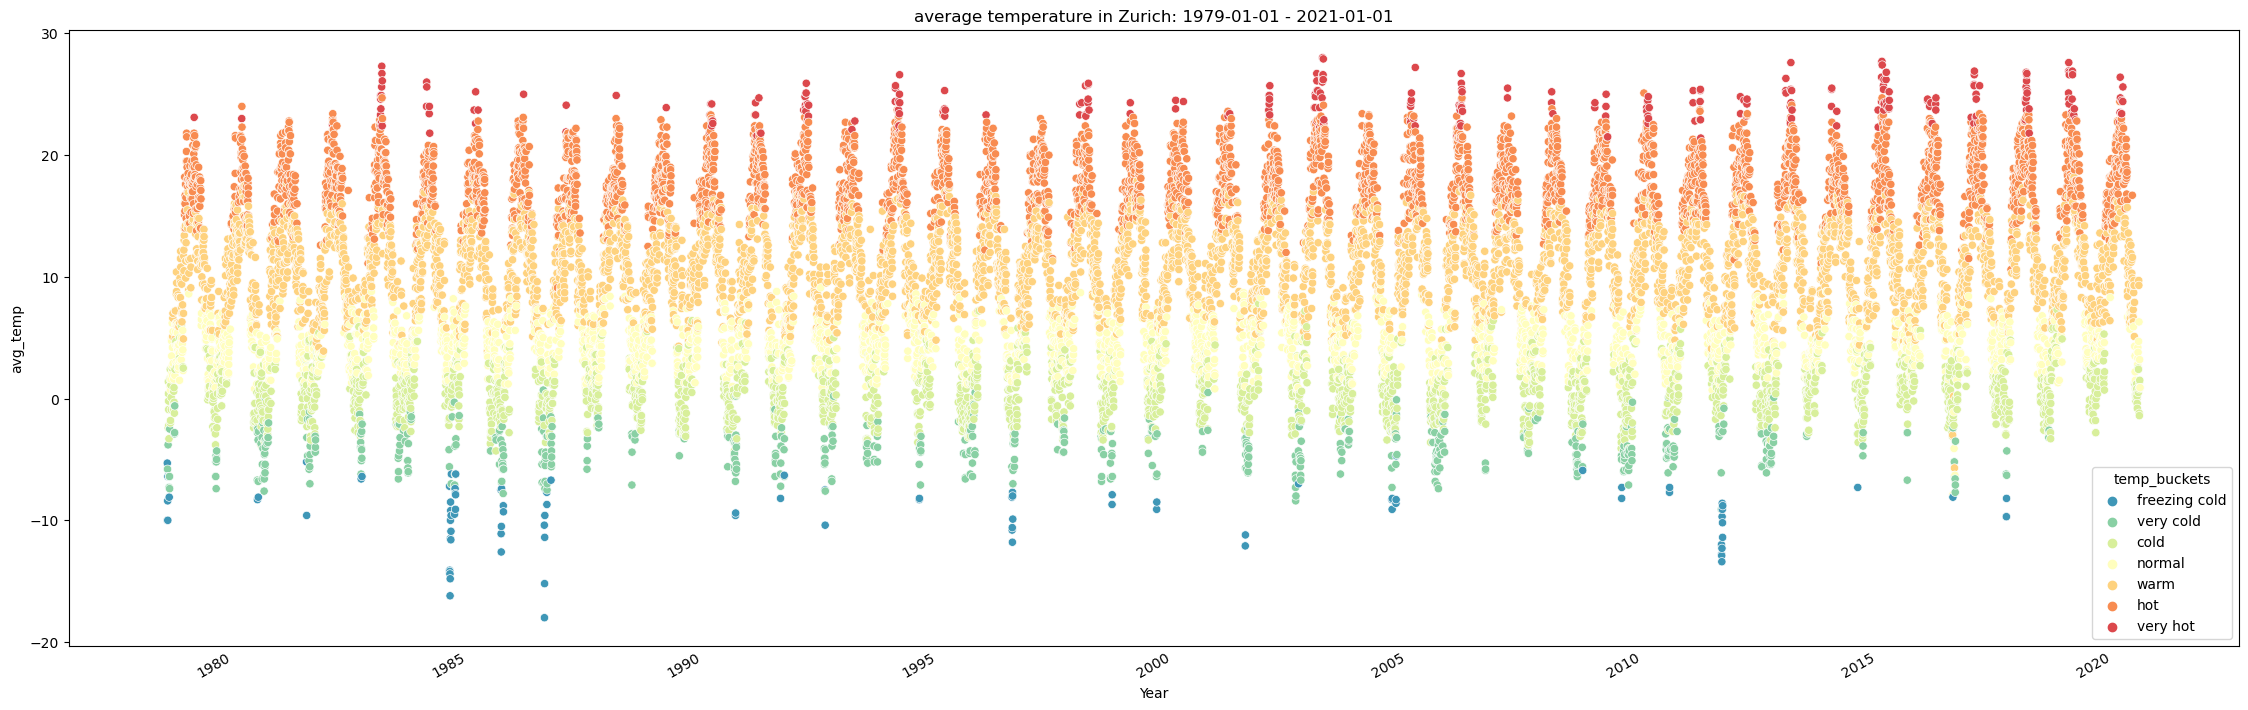

In [17]:
# set kich thuoc cho bieu do phan tan
fig, ax = plt.subplots(figsize=(28,8))
sns.scatterplot(hue="temp_buckets", y="avg_temp", x="date", data=spark_cleaned_df.toPandas(), palette="Spectral_r")

# dinh dang plot
ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)

# dinh dang title
mindate = str(spark_cleaned_df.agg({'date': 'min'}).collect()[0]['min(date)'])
maxdate = str(spark_cleaned_df.agg({'date': 'max'}).collect()[0]['max(date)'])
ax.set_title("average temperature in Zurich: " + mindate + " - " + maxdate)
plt.xlabel("Year")
plt.show()

<AxesSubplot:xlabel='year', ylabel='month'>

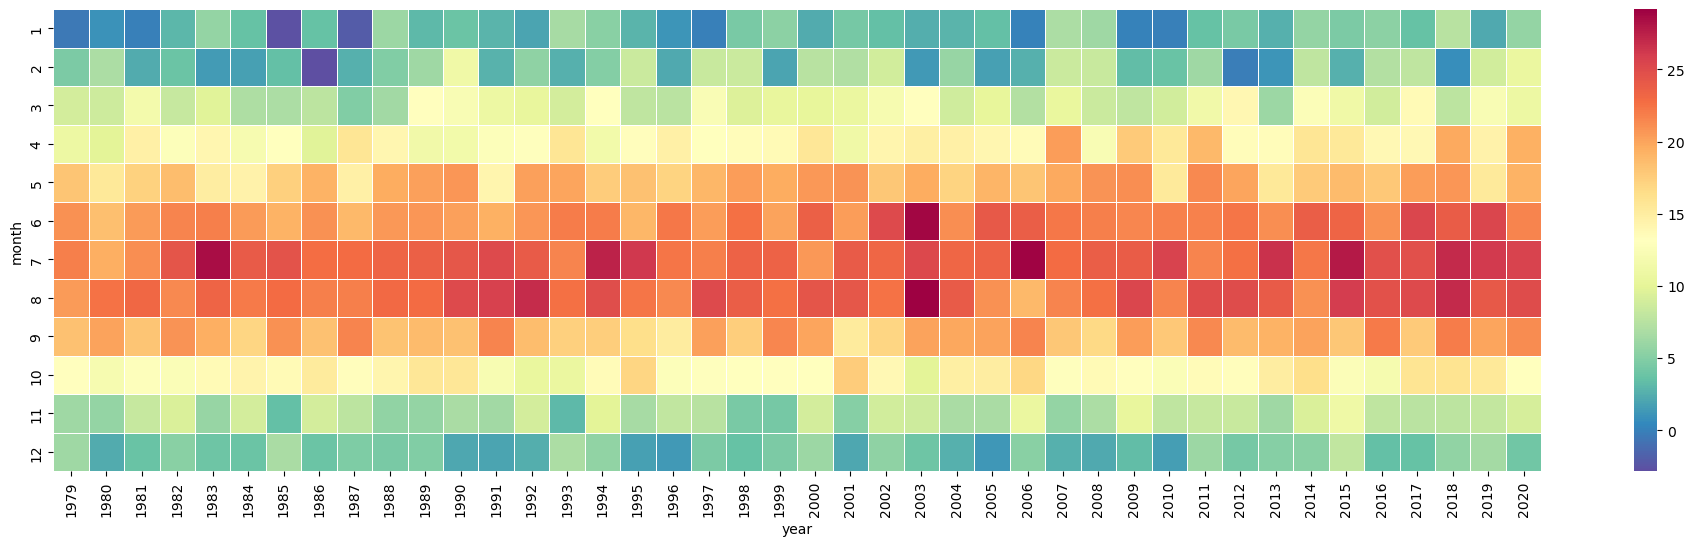

In [18]:
spark_cleaned_df_agg = spark_cleaned_df.select(col("year"),col("month"),col("max_temp")) \
    .filter(spark_cleaned_df.year < 2021)\
    .groupby(col("year"),col("month"))\
    .agg(mean("max_temp").alias("mean_max_temp")) \
    .orderBy(col("year")).toPandas()

plt.figure(figsize=(24,6))
avg_temp_df = spark_cleaned_df_agg.pivot("month", "year", "mean_max_temp")
sns.heatmap(avg_temp_df, cmap="Spectral_r", linewidths=.5)

Text(0.5, 1.0, 'min - max temperature seperated by month')

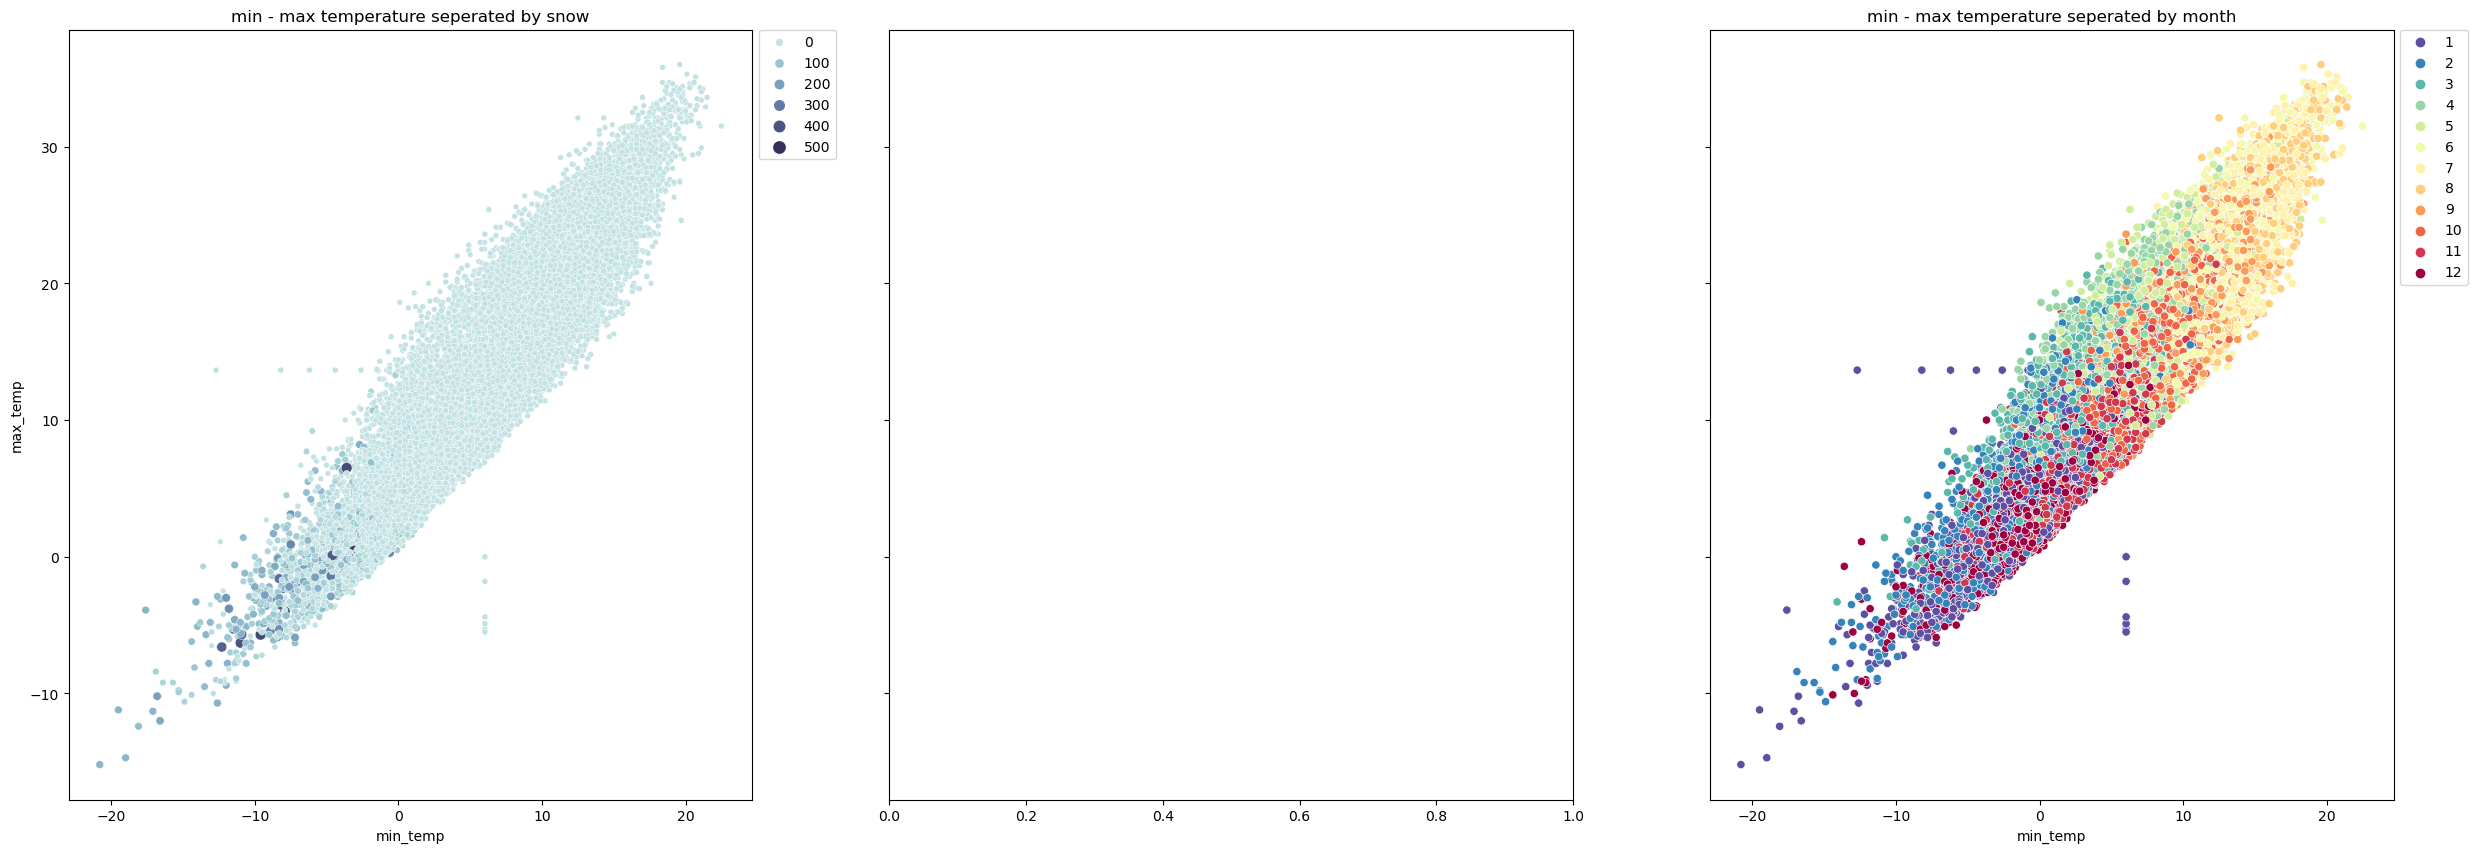

In [19]:
fig, axes= plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(30, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.2)

palette = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)
sns.scatterplot(ax = axes[0], hue="snow", size="snow", y="max_temp", x="min_temp", data=spark_cleaned_df.toPandas(), alpha=1.0, palette=palette)
axes[0].legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
axes[0].set_title("min - max temperature seperated by snow")


sns.scatterplot(ax = axes[2], hue="month", y="max_temp", x="min_temp", data=spark_cleaned_df.toPandas(), alpha=1.0, palette='Spectral_r', hue_norm=(1,12), legend="full")
axes[2].legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
axes[2].set_title("min - max temperature seperated by month")

In [20]:
!pip install neuralprophet

     -------------------------------------- 113.6/113.6 kB 1.3 MB/s eta 0:00:00
     ---------------------------------------- 1.4/1.4 MB 3.9 MB/s eta 0:00:00
     -------------------------------------- 162.5/162.5 MB 1.3 MB/s eta 0:00:00
     -------------------------------------- 47.9/47.9 kB 801.8 kB/s eta 0:00:00
     -------------------------------------- 232.0/232.0 kB 2.4 MB/s eta 0:00:00
     -------------------------------------- 419.6/419.6 kB 1.6 MB/s eta 0:00:00
     -------------------------------------- 196.0/196.0 kB 1.1 MB/s eta 0:00:00
     -------------------------------------- 706.5/706.5 kB 2.2 MB/s eta 0:00:00
     ---------------------------------------- 6.0/6.0 MB 959.1 kB/s eta 0:00:00
     ---------------------------------------- 51.1/51.1 kB ? eta 0:00:00
     ---------------------------------------- 5.8/5.8 MB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ------------------------

In [21]:
spark_cleaned_df = spark_cleaned_df.drop(col("min_temp"))\
    .drop(col("max_temp"))\
    .drop(col("date2")) \
    .drop(col("snow")) \
    .drop(col("precip")) \
    .drop(col("temp_buckets")) \
    .drop(col("precip_buckets")) \
    .drop(col("month")) \
    .drop(col("year")) 
quick_overview(spark_cleaned_df)

FIRST RECORDS
         date  avg_temp
0  1979-01-01      -5.3
1  1979-01-02     -10.0
COUNT NULL VALUES
   avg_temp
0         0


AnalysisException: Resolved attribute(s) date#1021 missing from date#1367,avg_temp#1034 in operator !Aggregate [date#1021], [date#1021, count(1) AS count#1734L]. Attribute(s) with the same name appear in the operation: date. Please check if the right attribute(s) are used.;
!Aggregate [date#1021], [date#1021, count(1) AS count#1734L]
+- Project [date#1367, avg_temp#1034]
   +- Project [date#1367, avg_temp#1034, year#1504]
      +- Project [date#1367, avg_temp#1034, month#1494, year#1504]
         +- Project [date#1367, avg_temp#1034, precip_buckets#1485, month#1494, year#1504]
            +- Project [date#1367, avg_temp#1034, temp_buckets#1463, precip_buckets#1485, month#1494, year#1504]
               +- Project [date#1367, avg_temp#1034, precip#1035, temp_buckets#1463, precip_buckets#1485, month#1494, year#1504]
                  +- Project [date#1367, avg_temp#1034, snow#1322, precip#1035, temp_buckets#1463, precip_buckets#1485, month#1494, year#1504]
                     +- Project [date#1367, avg_temp#1034, snow#1322, precip#1035, temp_buckets#1463, precip_buckets#1485, month#1494, year#1504]
                        +- Project [date#1367, avg_temp#1034, max_temp#1272, snow#1322, precip#1035, temp_buckets#1463, precip_buckets#1485, month#1494, year#1504]
                           +- Project [date#1367, avg_temp#1034, min_temp#1247, max_temp#1272, snow#1322, precip#1035, temp_buckets#1463, precip_buckets#1485, month#1494, year(date#1367) AS year#1504]
                              +- Project [date#1367, avg_temp#1034, min_temp#1247, max_temp#1272, snow#1322, precip#1035, temp_buckets#1463, precip_buckets#1485, month(date#1367) AS month#1494]
                                 +- Project [date#1367, avg_temp#1034, min_temp#1247, max_temp#1272, snow#1322, precip#1035, temp_buckets#1463, <lambda>(precip#1035)#1484 AS precip_buckets#1485]
                                    +- Project [date#1367, avg_temp#1034, min_temp#1247, max_temp#1272, snow#1322, precip#1035, binner(min_temp#1247, max_temp#1272)#1462 AS temp_buckets#1463]
                                       +- Project [date#1367, avg_temp#1034, min_temp#1247, max_temp#1272, snow#1322, precip#1035]
                                          +- Sort [date#1367 ASC NULLS FIRST], true
                                             +- Project [avg_temp#1034, precip#1035, snow#1322, _c5#1037, _c6#1038, _c7#1039, _c8#1040, _c9#1041, to_date(date#1021, Some(yyyy-MM-dd), Some(Asia/Bangkok)) AS date#1367, max_temp#1272, min_temp#1247]
                                                +- Project [avg_temp#1034, precip#1035, snow#1322, _c5#1037, _c6#1038, _c7#1039, _c8#1040, _c9#1041, date#1021, max_temp#1272, min_temp#1247]
                                                   +- Deduplicate [snow#1322, precip#1035, _c5#1037, avg_temp#1034, min_temp#1247, _c9#1041, _c8#1040, max_temp#1272, date2#1033, date#1021, _c7#1039, _c6#1038]
                                                      +- Project [date2#1033, avg_temp#1034, precip#1035, coalesce(nanvl(snow#1297, cast(null as double)), cast(0.0 as double)) AS snow#1322, _c5#1037, _c6#1038, _c7#1039, _c8#1040, _c9#1041, date#1021, max_temp#1272, min_temp#1247]
                                                         +- Project [date2#1033, avg_temp#1034, precip#1035, coalesce(nanvl(snow#1036, cast(null as double)), cast(8.01294033069734 as double)) AS snow#1297, _c5#1037, _c6#1038, _c7#1039, _c8#1040, _c9#1041, date#1021, max_temp#1272, min_temp#1247]
                                                            +- Project [date2#1033, avg_temp#1034, precip#1035, snow#1036, _c5#1037, _c6#1038, _c7#1039, _c8#1040, _c9#1041, date#1021, coalesce(nanvl(max_temp#1025, cast(null as double)), cast(13.652633624878481 as double)) AS max_temp#1272, min_temp#1247]
                                                               +- Project [date2#1033, avg_temp#1034, precip#1035, snow#1036, _c5#1037, _c6#1038, _c7#1039, _c8#1040, _c9#1041, date#1021, max_temp#1025, coalesce(nanvl(min_temp#1029, cast(null as double)), cast(6.02912048739385 as double)) AS min_temp#1247]
                                                                  +- Filter isnotnull(avg_temp#1034)
                                                                     +- Join Inner, (date2#1033 = date#1021)
                                                                        :- Project [_c1#18 AS date2#1033, _c2#19 AS avg_temp#1034, _c3#20 AS precip#1035, _c4#21 AS snow#1036, _c5#22 AS _c5#1037, _c6#23 AS _c6#1038, _c7#24 AS _c7#1039, _c8#25 AS _c8#1040, _c9#26 AS _c9#1041]
                                                                        :  +- Project [_c1#18, _c2#19, _c3#20, _c4#21, _c5#22, _c6#23, _c7#24, _c8#25, _c9#26]
                                                                        :     +- Relation [_c0#17,_c1#18,_c2#19,_c3#20,_c4#21,_c5#22,_c6#23,_c7#24,_c8#25,_c9#26] csv
                                                                        +- Project [date#1021, max_temp#1025, _c3#710 AS min_temp#1029]
                                                                           +- Project [date#1021, _c2#709 AS max_temp#1025, _c3#710]
                                                                              +- Project [_c1#708 AS date#1021, _c2#709, _c3#710]
                                                                                 +- Project [_c1#708, _c2#709, _c3#710]
                                                                                    +- Relation [_c0#707,_c1#708,_c2#709,_c3#710] csv


In [22]:
from neuralprophet import NeuralProphet

In [23]:
m = NeuralProphet()
m.fit(spark_cleaned_df, freq='D', epochs=1000)

ValueError: Please, insert valid df type (pd.DataFrame)

In [24]:
spark_cleaned_df.limit(5).toPandas()

,date,avg_temp
0,1979-01-01,-5.3
1,1979-01-02,-10.0
2,1979-01-03,-5.8
3,1979-01-04,-8.4
4,1979-01-05,-10.0


In [25]:
import pandas as pd
import pickle

In [26]:
m = NeuralProphet()
m.fit(spark_cleaned_df, freq='D', epochs=1000)

ValueError: Please, insert valid df type (pd.DataFrame)

In [27]:
m = NeuralProphet()
m.fit(pd.spark_cleaned_df, freq='D', epochs=1000)

AttributeError: module 'pandas' has no attribute 'spark_cleaned_df'

In [28]:
spark_cleaned_df.head()

Row(date=datetime.date(1979, 1, 1), avg_temp=-5.3)

In [29]:
data = spark_cleaned_df[['date', 'avg_temp']]
data.columns = ['ds','y' ]
data.head()

AttributeError: can't set attribute

In [30]:
spark_cleaned_df.columns

['date', 'avg_temp']

In [31]:
spark_cleaned_df.dtypes

[('date', 'date'), ('avg_temp', 'double')]

In [32]:
spark_cleaned_df['date'] = pd.to_datetime(spark_cleaned_df['date'])
spark_cleaned_df.head()

ValueError: Cannot convert column into bool: please use '&' for 'and', '|' for 'or', '~' for 'not' when building DataFrame boolean expressions.

In [33]:
data = spark_cleaned_df[['date', 'avg_temp']]
data.dropna(inplace=True)
data.columns = ['ds', 'y']
data.head()

TypeError: dropna() got an unexpected keyword argument 'inplace'

In [34]:
data = spark_cleaned_df[['date', 'avg_temp']]
data.columns = ['ds', 'y']
data.head()

AttributeError: can't set attribute

In [35]:
spark_cleaned_df.head()

Row(date=datetime.date(1979, 1, 1), avg_temp=-5.3)

In [36]:
spark_cleaned_df.limit(10).toPandas()

,date,avg_temp
0,1979-01-01,-5.3
1,1979-01-02,-10.0
2,1979-01-03,-5.8
3,1979-01-04,-8.4
4,1979-01-05,-10.0
5,1979-01-06,-6.4
6,1979-01-07,-3.8
7,1979-01-08,-2.4
8,1979-01-09,1.4
9,1979-01-10,0.4


In [37]:
data.head()

Row(date=datetime.date(1979, 1, 1), avg_temp=-5.3)

In [38]:
m = NeuralProphet()
m.fit(data, freq='D', epochs=1000)

ValueError: Please, insert valid df type (pd.DataFrame)

In [39]:
import pyspark.sql.functions as F

spark_cleaned_df.withColumn('date', F.to_timestamp('date', format='dd MMM yyyy HH:mm:ss'))

DataFrame[date: timestamp, avg_temp: double]

In [40]:
spark_cleaned_df.dtypes

[('date', 'date'), ('avg_temp', 'double')]

In [41]:
m = NeuralProphet()
m.fit(data, freq='D', epochs=1000)

ValueError: Please, insert valid df type (pd.DataFrame)

In [42]:
data.dtypes

[('date', 'date'), ('avg_temp', 'double')]

In [43]:
data.columns = ["ds", "y"]

AttributeError: can't set attribute

In [46]:

# Select columns
temp = data[["date", "avg_temp"]]
# Prophet wants us to name columns as shown below
temp.columns = ["ds", "y"]
# instantiate the model and set parameters
model = Prophet(
    interval_width=0.95,
    growth='linear',
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode='multiplicative'
)
# fit the model to historical data
model.fit(s1i1);

AttributeError: can't set attribute

In [47]:
from pyspark.sql.functions import col

data = data.select(col("date").alias("ds"), col("avg_temp").alias("y"))
data.show()


+----------+-----+
|        ds|    y|
+----------+-----+
|1979-01-01| -5.3|
|1979-01-02|-10.0|
|1979-01-03| -5.8|
|1979-01-04| -8.4|
|1979-01-05|-10.0|
|1979-01-06| -6.4|
|1979-01-07| -3.8|
|1979-01-08| -2.4|
|1979-01-09|  1.4|
|1979-01-10|  0.4|
|1979-01-11| -0.2|
|1979-01-12| -0.9|
|1979-01-13| -2.2|
|1979-01-14| -3.3|
|1979-01-15| -7.3|
|1979-01-16| -8.1|
|1979-01-17| -6.4|
|1979-01-18| -6.4|
|1979-01-19| -7.4|
|1979-01-20| -2.5|
+----------+-----+
only showing top 20 rows



In [48]:
m = NeuralProphet()
m.fit(data, freq='D', epochs=1000)

ValueError: Please, insert valid df type (pd.DataFrame)

In [49]:
# Select columns
temp = data[["date", "avg_temp"]]
# instantiate the model and set parameters
model = Prophet(
    interval_width=0.95,
    growth='linear',
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode='multiplicative'
)
# fit the model to historical data
model.fit(temp);

AnalysisException: Column 'date' does not exist. Did you mean one of the following? [ds, y];
'Project ['date, 'avg_temp]
+- Project [date#1367 AS ds#1806, avg_temp#1034 AS y#1807]
   +- Project [date#1367, avg_temp#1034]
      +- Project [date#1367, avg_temp#1034]
         +- Project [date#1367, avg_temp#1034, year#1504]
            +- Project [date#1367, avg_temp#1034, month#1494, year#1504]
               +- Project [date#1367, avg_temp#1034, precip_buckets#1485, month#1494, year#1504]
                  +- Project [date#1367, avg_temp#1034, temp_buckets#1463, precip_buckets#1485, month#1494, year#1504]
                     +- Project [date#1367, avg_temp#1034, precip#1035, temp_buckets#1463, precip_buckets#1485, month#1494, year#1504]
                        +- Project [date#1367, avg_temp#1034, snow#1322, precip#1035, temp_buckets#1463, precip_buckets#1485, month#1494, year#1504]
                           +- Project [date#1367, avg_temp#1034, snow#1322, precip#1035, temp_buckets#1463, precip_buckets#1485, month#1494, year#1504]
                              +- Project [date#1367, avg_temp#1034, max_temp#1272, snow#1322, precip#1035, temp_buckets#1463, precip_buckets#1485, month#1494, year#1504]
                                 +- Project [date#1367, avg_temp#1034, min_temp#1247, max_temp#1272, snow#1322, precip#1035, temp_buckets#1463, precip_buckets#1485, month#1494, year(date#1367) AS year#1504]
                                    +- Project [date#1367, avg_temp#1034, min_temp#1247, max_temp#1272, snow#1322, precip#1035, temp_buckets#1463, precip_buckets#1485, month(date#1367) AS month#1494]
                                       +- Project [date#1367, avg_temp#1034, min_temp#1247, max_temp#1272, snow#1322, precip#1035, temp_buckets#1463, <lambda>(precip#1035)#1484 AS precip_buckets#1485]
                                          +- Project [date#1367, avg_temp#1034, min_temp#1247, max_temp#1272, snow#1322, precip#1035, binner(min_temp#1247, max_temp#1272)#1462 AS temp_buckets#1463]
                                             +- Project [date#1367, avg_temp#1034, min_temp#1247, max_temp#1272, snow#1322, precip#1035]
                                                +- Sort [date#1367 ASC NULLS FIRST], true
                                                   +- Project [avg_temp#1034, precip#1035, snow#1322, _c5#1037, _c6#1038, _c7#1039, _c8#1040, _c9#1041, to_date(date#1021, Some(yyyy-MM-dd), Some(Asia/Bangkok)) AS date#1367, max_temp#1272, min_temp#1247]
                                                      +- Project [avg_temp#1034, precip#1035, snow#1322, _c5#1037, _c6#1038, _c7#1039, _c8#1040, _c9#1041, date#1021, max_temp#1272, min_temp#1247]
                                                         +- Deduplicate [snow#1322, precip#1035, _c5#1037, avg_temp#1034, min_temp#1247, _c9#1041, _c8#1040, max_temp#1272, date2#1033, date#1021, _c7#1039, _c6#1038]
                                                            +- Project [date2#1033, avg_temp#1034, precip#1035, coalesce(nanvl(snow#1297, cast(null as double)), cast(0.0 as double)) AS snow#1322, _c5#1037, _c6#1038, _c7#1039, _c8#1040, _c9#1041, date#1021, max_temp#1272, min_temp#1247]
                                                               +- Project [date2#1033, avg_temp#1034, precip#1035, coalesce(nanvl(snow#1036, cast(null as double)), cast(8.01294033069734 as double)) AS snow#1297, _c5#1037, _c6#1038, _c7#1039, _c8#1040, _c9#1041, date#1021, max_temp#1272, min_temp#1247]
                                                                  +- Project [date2#1033, avg_temp#1034, precip#1035, snow#1036, _c5#1037, _c6#1038, _c7#1039, _c8#1040, _c9#1041, date#1021, coalesce(nanvl(max_temp#1025, cast(null as double)), cast(13.652633624878481 as double)) AS max_temp#1272, min_temp#1247]
                                                                     +- Project [date2#1033, avg_temp#1034, precip#1035, snow#1036, _c5#1037, _c6#1038, _c7#1039, _c8#1040, _c9#1041, date#1021, max_temp#1025, coalesce(nanvl(min_temp#1029, cast(null as double)), cast(6.02912048739385 as double)) AS min_temp#1247]
                                                                        +- Filter isnotnull(avg_temp#1034)
                                                                           +- Join Inner, (date2#1033 = date#1021)
                                                                              :- Project [_c1#18 AS date2#1033, _c2#19 AS avg_temp#1034, _c3#20 AS precip#1035, _c4#21 AS snow#1036, _c5#22 AS _c5#1037, _c6#23 AS _c6#1038, _c7#24 AS _c7#1039, _c8#25 AS _c8#1040, _c9#26 AS _c9#1041]
                                                                              :  +- Project [_c1#18, _c2#19, _c3#20, _c4#21, _c5#22, _c6#23, _c7#24, _c8#25, _c9#26]
                                                                              :     +- Relation [_c0#17,_c1#18,_c2#19,_c3#20,_c4#21,_c5#22,_c6#23,_c7#24,_c8#25,_c9#26] csv
                                                                              +- Project [date#1021, max_temp#1025, _c3#710 AS min_temp#1029]
                                                                                 +- Project [date#1021, _c2#709 AS max_temp#1025, _c3#710]
                                                                                    +- Project [_c1#708 AS date#1021, _c2#709, _c3#710]
                                                                                       +- Project [_c1#708, _c2#709, _c3#710]
                                                                                          +- Relation [_c0#707,_c1#708,_c2#709,_c3#710] csv


In [50]:
model.fit(temp, freq='D', epochs=1000)

NameError: name 'model' is not defined

In [58]:
# Select columns
temp = data[["ds", "y"]]
# instantiate the model and set parameters
model = NeuralProphet()
# fit the model to historical data
model.fit(temp, freq='D', epochs=1000)

ValueError: Please, insert valid df type (pd.DataFrame)

In [54]:
# Select columns
temp = data[['ds', 'y']]
# instantiate the model and set parameters
model = Prophet(
    interval_width=0.95,
    growth='linear',
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode='multiplicative'
)
# fit the model to historical data
model.fit(temp, freq='D', epochs=1000)

NameError: name 'Prophet' is not defined

In [53]:
data.show()

+----------+-----+
|        ds|    y|
+----------+-----+
|1979-01-01| -5.3|
|1979-01-02|-10.0|
|1979-01-03| -5.8|
|1979-01-04| -8.4|
|1979-01-05|-10.0|
|1979-01-06| -6.4|
|1979-01-07| -3.8|
|1979-01-08| -2.4|
|1979-01-09|  1.4|
|1979-01-10|  0.4|
|1979-01-11| -0.2|
|1979-01-12| -0.9|
|1979-01-13| -2.2|
|1979-01-14| -3.3|
|1979-01-15| -7.3|
|1979-01-16| -8.1|
|1979-01-17| -6.4|
|1979-01-18| -6.4|
|1979-01-19| -7.4|
|1979-01-20| -2.5|
+----------+-----+
only showing top 20 rows



In [59]:
spark_cleaned_df.show()

+----------+--------+
|      date|avg_temp|
+----------+--------+
|1979-01-01|    -5.3|
|1979-01-02|   -10.0|
|1979-01-03|    -5.8|
|1979-01-04|    -8.4|
|1979-01-05|   -10.0|
|1979-01-06|    -6.4|
|1979-01-07|    -3.8|
|1979-01-08|    -2.4|
|1979-01-09|     1.4|
|1979-01-10|     0.4|
|1979-01-11|    -0.2|
|1979-01-12|    -0.9|
|1979-01-13|    -2.2|
|1979-01-14|    -3.3|
|1979-01-15|    -7.3|
|1979-01-16|    -8.1|
|1979-01-17|    -6.4|
|1979-01-18|    -6.4|
|1979-01-19|    -7.4|
|1979-01-20|    -2.5|
+----------+--------+
only showing top 20 rows



In [60]:
pandas_cleaned_DF = pspark_cleaned_df.toPandas()
print(pandas_cleaned_DF)

NameError: name 'pspark_cleaned_df' is not defined

In [61]:
pandas_cleaned_DF = pypark_cleaned_df.toPandas()
print(pandas_cleaned_DF)

NameError: name 'pypark_cleaned_df' is not defined

In [62]:
pandas_cleaned_DF = spark_cleaned_df.toPandas()
print(pandas_cleaned_DF)

             date  avg_temp
0      1979-01-01      -5.3
1      1979-01-02     -10.0
2      1979-01-03      -5.8
3      1979-01-04      -8.4
4      1979-01-05     -10.0
...           ...       ...
15316  2020-12-28       1.4
15317  2020-12-29       3.2
15318  2020-12-30       1.5
15319  2020-12-31       0.9
15320  2021-01-01       0.9

[15321 rows x 2 columns]


In [63]:
pandas_cleaned_DF.columns = ['ds', 'y']
pandas_cleaned_DF.show()

AttributeError: 'DataFrame' object has no attribute 'show'

In [64]:
pandas_cleaned_DF.columns = ['ds', 'y']
pandas_cleaned_DF.head()

,ds,y
0,1979-01-01,-5.3
1,1979-01-02,-10.0
2,1979-01-03,-5.8
3,1979-01-04,-8.4
4,1979-01-05,-10.0


In [65]:
m = NeuralProphet()
m.fit(pandas_cleaned_DF, freq='D', epochs=1000)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.883% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (240) is too small than the required number for the learning rate finder (254). The results might not be optimal.


Finding best initial lr:   0%|          | 0/254 [00:00<?, ?it/s]

Missing logger folder: D:\doanBIGDATA\lightning_logs


Training: 0it [00:00, ?it/s]

,MAE,RMSE,Loss,RegLoss,epoch
0,68.381210,79.463768,0.986076,0.0,0
1,58.978840,68.628510,0.801663,0.0,1
2,49.826992,57.978321,0.622273,0.0,2
3,40.929493,47.459641,0.450813,0.0,3
4,32.522366,37.564758,0.296702,0.0,4
...,...,...,...,...,...
995,2.950531,3.626773,0.003223,0.0,995
996,2.953570,3.630291,0.003230,0.0,996
997,2.951836,3.626485,0.003225,0.0,997
998,2.952320,3.625067,0.003226,0.0,998


In [66]:
future = m.make_future_dataframe(pandas_cleaned_DF, periods=900)
forecast = m.predict(future)
forecast.head()

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.883% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.889% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.889% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 240it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,trend,season_yearly,season_weekly
0,2021-01-02,None,2.473806,10.935148,-8.473930,0.012588
1,2021-01-03,None,2.439564,10.935497,-8.501810,0.005877
2,2021-01-04,None,2.352968,10.935848,-8.530681,-0.052199
3,2021-01-05,None,2.358847,10.936195,-8.560493,-0.016856
4,2021-01-06,None,2.332924,10.936546,-8.591170,-0.012451


In [67]:
future

,ds,y
0,2021-01-02,None
1,2021-01-03,None
2,2021-01-04,None
3,2021-01-05,None
4,2021-01-06,None
...,...,...
895,2023-06-16,None
896,2023-06-17,None
897,2023-06-18,None
898,2023-06-19,None


In [68]:
forecast.tail()

,ds,y,yhat1,trend,season_yearly,season_weekly
895,2023-06-16,None,18.493320,11.247950,7.211169,0.034203
896,2023-06-17,None,18.561230,11.248301,7.300343,0.012588
897,2023-06-18,None,18.642563,11.248650,7.388037,0.005877
898,2023-06-19,None,18.671078,11.248999,7.474279,-0.052199
899,2023-06-20,None,18.791592,11.249350,7.559099,-0.016856


WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


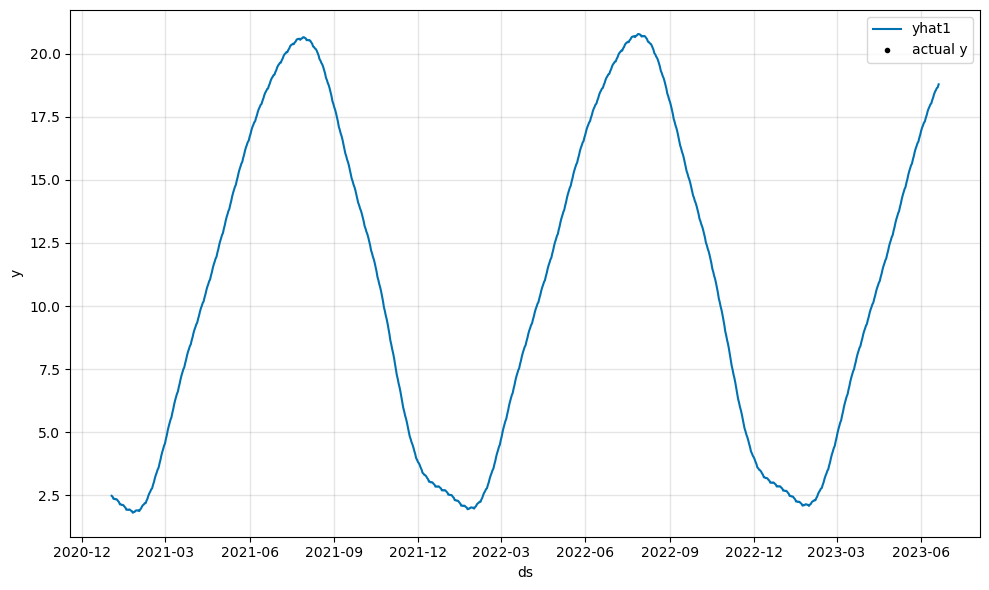

In [69]:
plot1 = m.plot(forecast)

WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


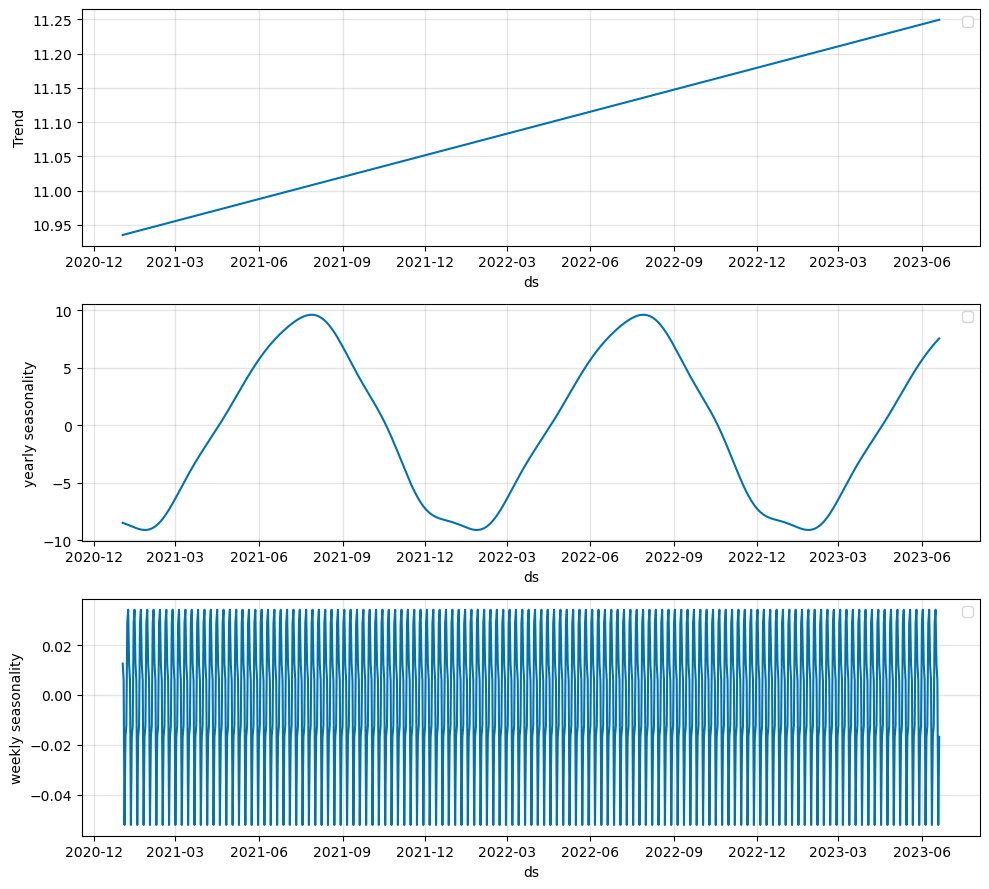

In [70]:
plot2 = m.plot_components(forecast)